<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - User Story 3
## On-demand processing of Sentinel-1 data
- CARDL compliant data
- With custom parametrization
- Sigma to Gamma ratio
- Timeseries comparison with different pre-processing toolchains

In [225]:
from eo_utils import *

## Step 1 -  Area of Interest selection
### Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [226]:
center = [46.49, 11.35]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.49, 11.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Get the bounding box from the previous map.

In [227]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 11.255493 
east 11.377716 
south 46.465358 
north 46.528698


<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## Step 1 - openEO graph creation for CARD4L ARD Sentinel-1 processed with SentinelHub

1. Open the connection with openEO back-end. Please use the openeo-auth tool to configure credentials.
https://open-eo.github.io/openeo-python-client/auth.html#config-files-and-openeo-auth-helper-tool

In [228]:
vito_backend_url = "https://openeo.vito.be"
vito_conn = openeo.connect(vito_backend_url).authenticate_basic()

2. Define range of interest in time for Sentinel-1

In [229]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-06", "2021-01-08"]
bands           = ["VV","VH"]

s1 = vito_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

3. Apply the CARDL compliant SAR processing.

In [230]:
s1bs = s1.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")

4. Save process as final step, here we use NetCDF as output format.

In [231]:
s1bs_netcdf = s1bs.save_result(format="NetCDF")

5. Now we will create a batch job and start it. More info about batch jobs can be found here:

    https://openeo.org/documentation/1.0/glossary.html#data-processing-modes

    https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [232]:
job_vito = vito_conn.create_job(s1bs_netcdf.graph)
job_id_vito = job_vito.job_id
if job_id_vito:
    print("Batch job created with id: ",job_id_vito)
    job_vito.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  6d266445-6a10-46b3-a986-539365cc999f


If our area of interest is small, we can also do a direct request, but this will not return the CARD4L json metadata. Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [238]:
%time s1bs.download("./data/US3/card4l_out.nc",format="NetCDF")

CPU times: user 184 ms, sys: 140 ms, total: 324 ms
Wall time: 26.7 s


We can get a description of the job and check its status.

In [246]:
job_vito = vito_conn.job(job_id_vito)
job_description = job_vito.describe_job()
print("Batch job with id: ",job_id_vito, ' is ',job_description['status'])

Batch job with id:  6d266445-6a10-46b3-a986-539365cc999f  is  finished


In [247]:
results = job_vito.get_results()
results

<JobResults for job '6d266445-6a10-46b3-a986-539365cc999f'>

In [250]:
results.get_metadata()

{'assets': {'out': {'card4l:nodata': 0.0,
   'eo:bands': [{'center_wavelength': None, 'name': 'VV'},
    {'center_wavelength': None, 'name': 'VH'},
    {'center_wavelength': None, 'name': 'mask'},
    {'center_wavelength': None, 'name': 'local_incidence_angle'}],
   'href': 'https://openeo.vito.be/openeo/1.0/jobs/6d266445-6a10-46b3-a986-539365cc999f/results/out',
   'type': 'application/x-netcdf'},
  's1_rtc_02FB1E_N46E011_2021_01_07_MULTIBAND.tif': {'href': 'https://openeo.vito.be/openeo/1.0/jobs/6d266445-6a10-46b3-a986-539365cc999f/results/s1_rtc_02FB1E_N46E011_2021_01_07_MULTIBAND.tif',
   'type': 'image/tiff; application=geotiff'},
  's1_rtc_02FB1E_N46E011_2021_01_07_metadata.json': {'href': 'https://openeo.vito.be/openeo/1.0/jobs/6d266445-6a10-46b3-a986-539365cc999f/results/s1_rtc_02FB1E_N46E011_2021_01_07_metadata.json',
   'type': 'application/json'},
  's1_rtc_04393F_N46E011_2021_01_08_MULTIBAND.tif': {'href': 'https://openeo.vito.be/openeo/1.0/jobs/6d266445-6a10-46b3-a986-5393

### Download complete result with metadata and source files
CARD4L results contain STAC metadata and the requested image. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

The downloaded data can be opened, but these are fairly large files, making visualization more difficult.

The foreseen way of interacting with it is to use openEO to further process the dataset into a more manageable result.

In [26]:
# sar = xr.open_rasterio('s1_rtc_02F8D2_N46E011_2021_01_02_MULTIBAND.tif')
# sar

<xarray.DataArray (band: 4, y: 5000, x: 5000)>
[100000000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 47.0 47.0 47.0 47.0 47.0 ... 46.0 46.0 46.0 46.0 46.0
  * x        (x) float64 11.0 11.0 11.0 11.0 11.0 ... 12.0 12.0 12.0 12.0 12.0
Attributes:
    transform:               (0.0002, 0.0, 11.0, 0.0, -0.0002, 47.0)
    crs:                     +init=epsg:4326
    res:                     (0.0002, 0.0002)
    is_tiled:                1
    nodatavals:              (nan, nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### Output visualization

In [242]:
S1_ard = xr.open_dataset("./data/US3/card4l_out.nc")
S1_ard

<xarray.Dataset>
Dimensions:                (t: 2, x: 918, y: 732)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-07 2021-01-08
  * x                      (x) float64 6.732e+05 6.732e+05 ... 6.823e+05
  * y                      (y) float64 5.148e+06 5.148e+06 ... 5.156e+06
Data variables:
    VH                     (t, y, x) float32 ...
    VV                     (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
Attributes:
    nodata:   0.0
    crs:      +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

Text(0.5, 1.0, 'VH gamma0')

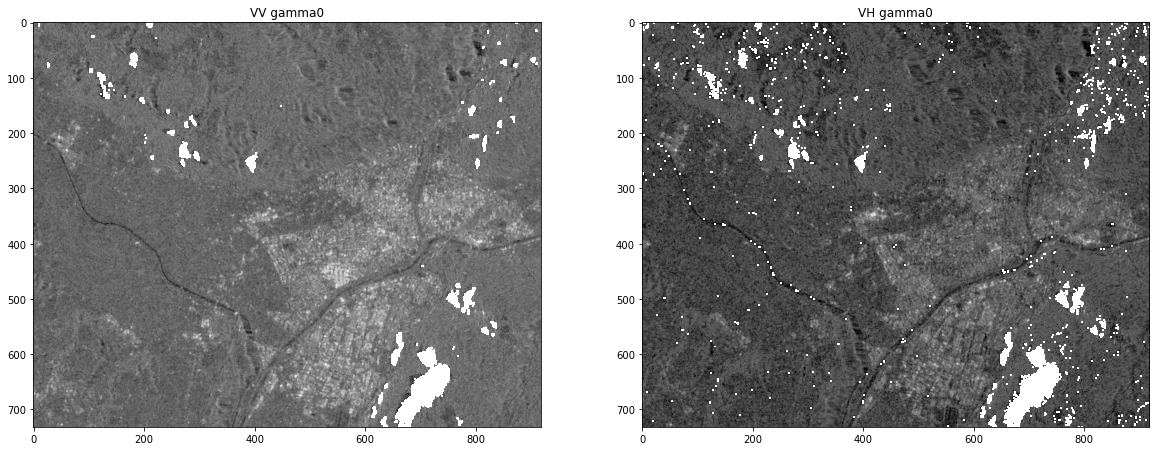

In [245]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(np.flipud(10* np.log10(S1_ard.VV[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0')
ax2.imshow(np.flipud(10* np.log10(S1_ard.VH[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0')

## If we don't need CARDL compliant data, we can also use the sar_backscatter process:

In [164]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-01", "2021-01-05"]
bands           = ["VV","VH"]

s1 = vito_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

### Sigma0:

In [165]:
s1_sigma = s1.sar_backscatter(coefficient='sigma0-ellipsoid').apply(lambda x: 10 * x.log(base=10))

In [169]:
%time s1_sigma.download("./data/US3/s1_sigma.nc",format="NetCDF")

CPU times: user 100 ms, sys: 84 ms, total: 184 ms
Wall time: 15.1 s


### Gamma0:

In [167]:
s1_gamma = s1.sar_backscatter(coefficient='gamma0-ellipsoid').apply(lambda x: 10 * x.log(base=10))

In [170]:
%time s1_gamma.download("./data/US3/s1_gamma.nc",format="NetCDF")

CPU times: user 96 ms, sys: 80 ms, total: 176 ms
Wall time: 14.2 s


In [171]:
s1_sigma0 = xr.open_dataset('./data/US3/s1_sigma.nc')
s1_gamma0 = xr.open_dataset('./data/US3/s1_gamma.nc')

Text(0.5, 1.0, 'Sigma VH')

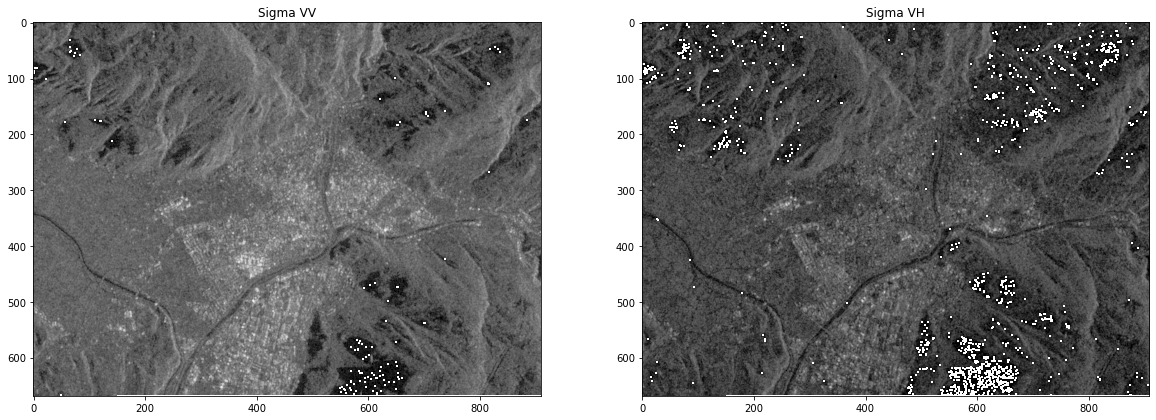

In [172]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(np.flipud(s1_sigma0.VV[1].values),cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('Sigma VV')
ax2.imshow(np.flipud(s1_sigma0.VH[1].values),cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('Sigma VH')

Text(0.5, 1.0, 'Gamma VH')

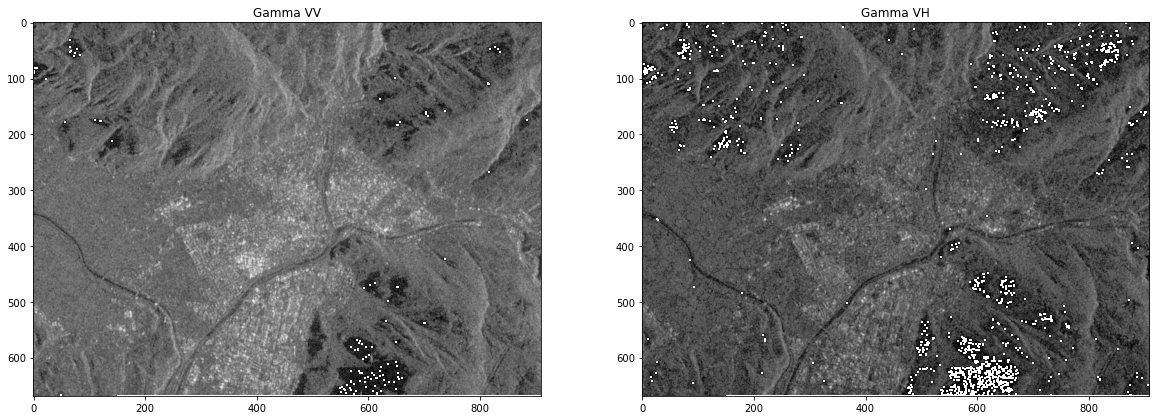

In [173]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(np.flipud(s1_gamma0.VV[1].values),cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('Gamma VV')
ax2.imshow(np.flipud(s1_gamma0.VH[1].values),cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('Gamma VH')

### Sigma To Gamma Ratio

Text(0.5, 1.0, 'Sigma/Gamma VH')

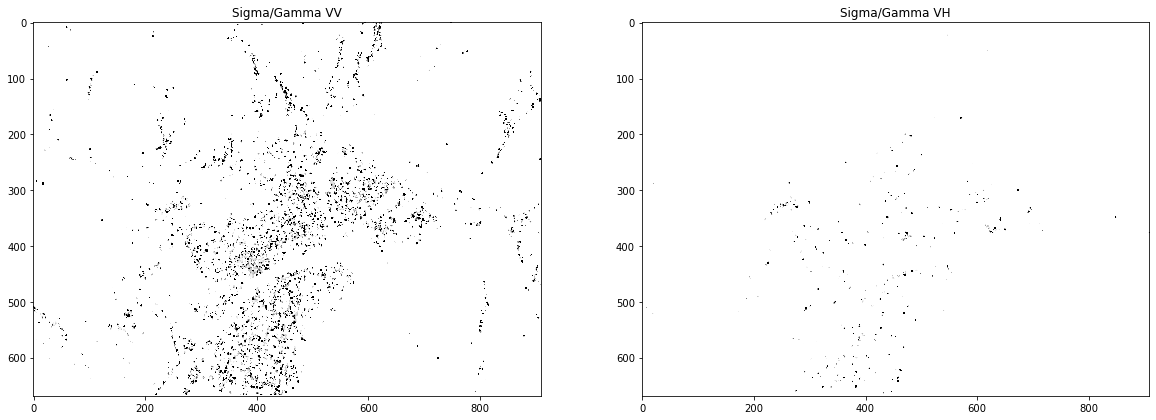

In [174]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(np.flipud(s1_sigma0.VV[1].values/s1_gamma0.VV[1].values),cmap='Greys_r',vmin=0,vmax=1)
ax1.set_title('Sigma/Gamma VV')
ax2.imshow(np.flipud(s1_sigma0.VH[1].values/s1_gamma0.VH[1].values),cmap='Greys_r',vmin=0,vmax=1)
ax2.set_title('Sigma/Gamma VH')

## Timeseries comparison

Next to requesting CARD4L backscatter data on SentinelHub, we can also generate Sigma0 backscatter on CreoDIAS.

In [215]:
backend_url = "https://openeo.creo.vito.be"
creo_conn = openeo.connect(backend_url).authenticate_basic()

In [216]:
W, S = 510000, 5680000
bbox = {
    "west": W, "east": W + 32 * 10,
    "south": S, "north": S + 32 * 10,
    "crs": 32631
}

dates = ("2020-05-06T00:00:00", "2020-09-30T00:00:00")

In [217]:
def backscatter(connection):
    return (connection.load_collection("SENTINEL1_GRD")
    .filter_bbox(**bbox)
    .filter_temporal(dates)
    .filter_bands(["VH", "VV"])
    .sar_backscatter(coefficient="sigma0-ellipsoid")
    .apply(lambda x: 10 * x.log(base=10)))


In [218]:
%%time
backscatter(creo_conn).download("./data/US3/creo-series.nc", format="NetCDF")

CPU times: user 36 ms, sys: 16 ms, total: 52 ms
Wall time: 2min 21s


In [219]:
%%time
backscatter(vito_conn).download("./data/US3/shub-series.nc", format="NetCDF")

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 15.1 s


In [220]:
%%time
asc = (vito_conn.load_collection("S1_GRD_SIGMA0_ASCENDING").filter_bbox(**bbox)
    .filter_temporal(dates)
    .filter_bands(["VH", "VV"]))
desc = (vito_conn.load_collection("S1_GRD_SIGMA0_DESCENDING").filter_bbox(**bbox)
    .filter_temporal(dates)
    .filter_bands(["VH", "VV"]))
desc.merge_cubes(asc,overlap_resolver="max").apply(lambda x: 10 * x.log(base=10)).download("./data/US3/snap-series.nc", format="NetCDF") 

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 14 s


In [182]:
creo_ts = xr.open_dataset("./data/US3/creo-series.nc",engine="h5netcdf")
creo_ts

<xarray.Dataset>
Dimensions:  (t: 98, x: 32, y: 32)
Coordinates:
  * t        (t) datetime64[ns] 2020-05-07 2020-05-08 ... 2020-09-28 2020-09-29
  * x        (x) float64 5.1e+05 5.1e+05 5.1e+05 ... 5.103e+05 5.103e+05
  * y        (y) float64 5.68e+06 5.68e+06 5.68e+06 ... 5.68e+06 5.68e+06
Data variables:
    VH       (t, y, x) float32 ...
    VV       (t, y, x) float32 ...
Attributes:
    crs:      +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs 
    nodata:   nan

In [183]:
shub_ts = xr.open_dataset("./data/US3/shub-series.nc",engine="h5netcdf")
shub_ts

<xarray.Dataset>
Dimensions:  (t: 98, x: 32, y: 32)
Coordinates:
  * t        (t) datetime64[ns] 2020-05-07 2020-05-08 ... 2020-09-28 2020-09-29
  * x        (x) float64 5.1e+05 5.1e+05 5.1e+05 ... 5.103e+05 5.103e+05
  * y        (y) float64 5.68e+06 5.68e+06 5.68e+06 ... 5.68e+06 5.68e+06
Data variables:
    VH       (t, y, x) float32 ...
    VV       (t, y, x) float32 ...
Attributes:
    crs:      +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs 
    nodata:   nan

In [184]:
snap_ts = xr.open_dataset("./data/US3/snap-series.nc",engine="h5netcdf")
snap_ts

<xarray.Dataset>
Dimensions:  (t: 98, x: 32, y: 32)
Coordinates:
  * t        (t) datetime64[ns] 2020-05-07 2020-05-08 ... 2020-09-28 2020-09-29
  * x        (x) float64 5.1e+05 5.1e+05 5.1e+05 ... 5.103e+05 5.103e+05
  * y        (y) float64 5.68e+06 5.68e+06 5.68e+06 ... 5.68e+06 5.68e+06
Data variables:
    VH       (t, y, x) float32 ...
    VV       (t, y, x) float32 ...
Attributes:
    crs:      +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs 
    nodata:   nan

Compute the mean value, for each timestamp. OpenEO can also do this for you.

In [221]:
xr.merge([creo_ts, shub_ts.rename({"VV": "VV_SHUB", "VH":"VH_SHUB"}), snap_ts.rename({"VV": "VV_SNAP", "VH":"VH_SNAP"})]).mean(dim=['x','y']).hvplot(width=1000,height=600)

:NdOverlay   [Variable]
   :Curve   [t]   (value)

<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## Step 2 - openEO graph creation for CARD4L ARD Sentinel-1 processed with SNAP

1. Open the connection with openEO back-end. Please use the openeo-auth tool to configure credentials.
https://open-eo.github.io/openeo-python-client/auth.html#config-files-and-openeo-auth-helper-tool

In [278]:
eodc_backend_url = "https://openeo.eodc.eu/v1.0"
eodc_conn = openeo.connect(eodc_backend_url).authenticate_basic()

Explore the pre-computed data and find the available dates over our area of interest:

In [254]:
itemIter = eodc_conn.collection_items(
    "gamma0_sentinel_1_dv",
    temporal_extent = ["2017-03-14", "2017-03-21"],
    spatial_extent = bbox
)

In [255]:
next(itemIter)

{'features': [{'assets': {'card4l': {'href': '/tmp/d672031c-d207-4736-96b3-f5bb9dc937e4/S1A_IW_GRDH_1SDV_20170319T170640_20170319T170705_015764_019F42_C1A3/S1A__IW___A_20170319T170640_NR_Orb_TF_TC_proc.xml',
     'roles': ['card4l', 'metadata'],
     'type': 'application/xml'},
    'data_mask': {'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'uint32',
     'file:values': [{'summary': 'No data value.', 'values': [0]}],
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/S1A__IW___A_20170319T170640_DVV_NR_Orb_TF_TC_EU010M_E048N014T1.tif',
     'roles': ['data-mask', 'metadata'],
     'type': 'image/tiff; application=geotiff'},
    'vh': {'created': '2021-03-18T10:47:31.847885+00:00',
     'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'float32',
     'file:nodata': [0.0],
     'file:unit': 'Watt',
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/S1A__IW___A_20170319T170640_DVH_NR_Orb_TF_TC_EU010M_E048N014T1.tif',
     'roles': ['data', 'backscatter'],
     'sar:polarizations': ['VH'],
     'type': 'image/tiff; application=geotiff'},
    'vv': {'created': '2021-03-18T10:47:31.847885+00:00',
     'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'float32',
     'file:nodata': [0.0],
     'file:unit': 'Watt',
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/S1A__IW___A_20170319T170640_DVV_NR_Orb_TF_TC_EU010M_E048N014T1.tif',
     'roles': ['data', 'backscatter'],
     'sar:polarizations': ['VV'],
     'type': 'image/tiff; application=geotiff'}},
   'bbox': [10.428304773879523,
    45.669999176576496,
    11.917989926569048,
    46.70859051248336],
   'geometry': {'coordinates': [[[10.428304773879523, 45.669999176576496],
      [10.428304773879523, 46.70859051248336],
      [11.917989926569048, 46.70859051248336],
      [11.917989926569048, 45.669999176576496],
      [10.428304773879523, 45.669999176576496]]],
    'type': 'Polygon'},
   'id': '3b860349-17df-4ec0-8454-5e7a6e2b83a3',
   'links': [{'href': 'https://ceos.org/ard/files/PFS/SR/v5.0/CARD4L_Product_Family_Specification_Surface_Reflectance-v5.0.pdf',
     'rel': 'card4l-document',
     'type': 'application/pdf'},
    {'href': 'https://sentinel.esa.int/documents/247904/2142675/Sentinel-1-masking-no-value-pixels-grd-products-note',
     'rel': 'noise-removale'},
    {'href': 'https://step.esa.int/main/doc/', 'rel': 'noise-removal'},
    {'href': 'http://step.esa.int/docs/tutorials/S1TBX%20SAR%20Basics%20Tutorial.pdf',
     'rel': 'radiometric-terrain-correction'},
    {'href': 'root', 'rel': 'https://openeo.eodc.eu/v1.0/collections'},
    {'href': 'https://openeo.eodc.eu/v1.0/collections/gamma0_sentinel_1_dv/items',
     'rel': 'parent'},
    {'href': 'https://openeo.eodc.eu/v1.0/collections/gamma0_sentinel_1_dv/items/3b860349-17df-4ec0-8454-5e7a6e2b83a3',
     'rel': 'self'}],
   'properties': {'card4l:measurement_convention': 'power',
    'card4l:measurement_type': 'gamma0',
    'card4l:noise_removal_applied': True,
    'card4l:orbit_data_source': 'definitive',
    'card4l:pixel_coordinate_convention': 'upper-left',
    'card4l:specification': 'NRB',
    'card4l:specification_version': '5.0',
    'card4l:speckle_filtering': None,
    'constellation': 'sentinel-1',
    'datetime': '2017-03-19T17:06:40',
    'end_datetime': '2017-03-19T17:07:05',
    'gsd': 10.0,
    'instruments': ['c-sar'],
    'platform': 'sentinel-1a',
    'processing:facility': 'EODC-cloud',
    'processing:software': {'SNAP': '7.0'},
    'proj:epsg': None,
    'proj:wkt2': 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false

2. Define range of interest in time for Sentinel-1

In [279]:
collection      = 's1a_csar_grdh_iw'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2017-03-19", "2017-03-19"]
bands           = ["VV+VH"]

s1 = eodc_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

3. Apply the CARDL compliant SAR processing.

In [280]:
# s1bs = s1.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")
s1bs = s1.sar_backscatter()

4. Save process as final step, here we use GeoTIFF as output format.

In [281]:
s1bs_tif = s1bs.save_result(format="GTiff")

In [282]:
s1bs_tif.graph

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['VV+VH'],
   'id': 's1a_csar_grdh_iw',
   'spatial_extent': {'west': 11.255493,
    'east': 11.377716,
    'south': 46.465358,
    'north': 46.528698,
    'crs': 'EPSG:4326'},
   'temporal_extent': ['2017-03-19', '2017-03-19']}},
 'sarbackscatter1': {'process_id': 'sar_backscatter',
  'arguments': {'coefficient': 'gamma0-terrain',
   'contributing_area': False,
   'data': {'from_node': 'loadcollection1'},
   'elevation_model': None,
   'ellipsoid_incidence_angle': False,
   'local_incidence_angle': False,
   'mask': False,
   'noise_removal': True}},
 'saveresult1': {'process_id': 'save_result',
  'arguments': {'data': {'from_node': 'sarbackscatter1'},
   'format': 'GTiff',
   'options': {}},
  'result': True}}

5. Now we will create a batch job and start it. More info about batch jobs can be found here:

    https://openeo.org/documentation/1.0/glossary.html#data-processing-modes

    https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [273]:
job_eodc = eodc_conn.create_job(s1bs_tif.graph)
job_id_eodc = job_eodc.job_id
if job_id_eodc:
    print("Batch job created with id: ",job_id_eodc)
    job_eodc.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-027e8fe0-6889-46ef-8958-b52dbc768597


In [275]:
job_eodc = eodc_conn.job(job_id_eodc)
job_description = job_eodc.describe_job()
print("Batch job with id: ",job_id_eodc, ' is ',job_description['status'])

Batch job with id:  jb-027e8fe0-6889-46ef-8958-b52dbc768597  is  error


In [ ]:
results = job_eodc.get_results()
results

In [ ]:
results.download_file("./data/US3/card4l_snap.tif")

### Output visualization

In [242]:
S1_ard_snap = xr.open_dataset("./data/US3/card4l_snap.tif")
S1_ard_snap

<xarray.Dataset>
Dimensions:                (t: 2, x: 918, y: 732)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-07 2021-01-08
  * x                      (x) float64 6.732e+05 6.732e+05 ... 6.823e+05
  * y                      (y) float64 5.148e+06 5.148e+06 ... 5.156e+06
Data variables:
    VH                     (t, y, x) float32 ...
    VV                     (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
Attributes:
    nodata:   0.0
    crs:      +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

Text(0.5, 1.0, 'VH gamma0')

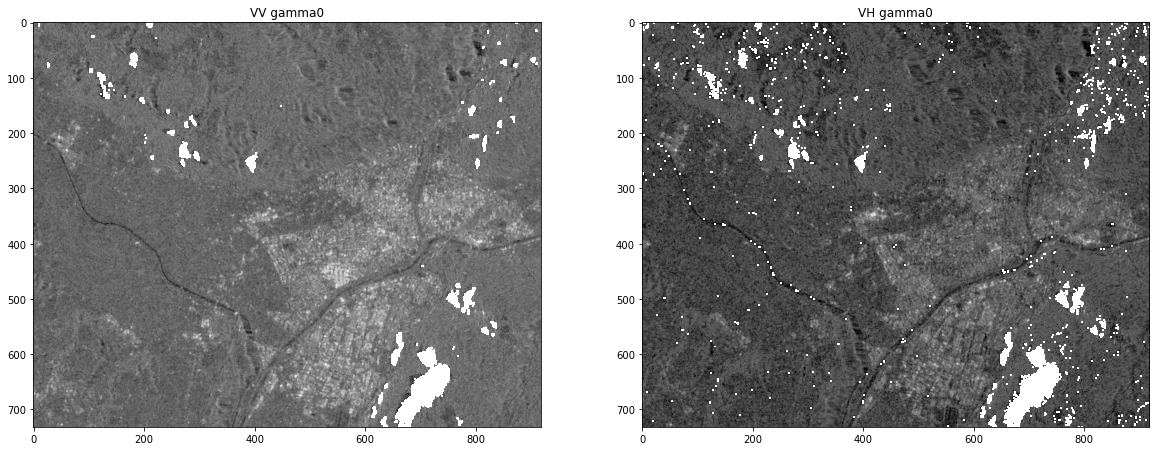

In [245]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(np.flipud(10* np.log10(S1_ard_snap.VV[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0 SNAP')
ax2.imshow(np.flipud(10* np.log10(S1_ard_snap.VH[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0 SNAP')